In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
import jkbc.utils.feature_importance as fi
import pandas as pd
import jkbc.utils.matrix_plot as mp

/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Get data

In [3]:
def combine(x, y, alpha):
    return x*alpha + y*(1-alpha)

In [16]:
df_raw = pd.read_csv('wandb/random_sweep.csv')
df_raw

,Name,ID,Name.1,State,Notes,User,Tags,Created,Runtime,Sweep,...,teacher,teacher_name,time_predict,weight_decay,ctc_loss,epoch,read_identity,time,train_loss,valid_loss
0,grateful-terrain-369,vy87ire6,grateful-terrain-369,crashed,-,jgfrausing,RANDOM_SWEEP,2020-05-28T07:18:21.000Z,2450,NaN,...,NaN,NaN,1.843034,0.1,NaN,3,0.861080,NaN,0.325531,0.386431
1,glowing-sea-275,10q27c43,glowing-sea-275,crashed,-,jgfrausing,RANDOM_SWEEP,2020-05-27T07:05:34.000Z,4345,NaN,...,NaN,NaN,3.923419,0.1,NaN,4,0.912327,NaN,0.216687,0.265584
2,wild-feather-400,3qnw1cad,wild-feather-400,crashed,-,jgfrausing,RANDOM_SWEEP,2020-05-29T15:36:24.000Z,3883,NaN,...,NaN,NaN,3.362575,0.1,0.277573,5,0.901688,NaN,0.212712,0.277573
3,sparkling-pond-399,2wobqmzv,sparkling-pond-399,crashed,-,kbargsteen,RANDOM_SWEEP,2020-05-29T15:23:15.000Z,5164,NaN,...,NaN,NaN,2.380895,0.1,NaN,6,0.903990,NaN,0.231117,0.275447
4,glad-feather-390,1jgx5gvl,glad-feather-390,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-29T05:13:12.000Z,4611,NaN,...,NaN,NaN,1.596016,0.1,0.321015,11,0.899822,NaN,0.166814,0.321015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,silver-river-195,2iepm7d5,silver-river-195,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T11:26:09.000Z,15194,NaN,...,NaN,NaN,2.145728,0.1,NaN,27,0.938367,NaN,0.101717,0.205918
132,dulcet-jazz-146,2vnbeih5,dulcet-jazz-146,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-23T07:51:17.000Z,12025,NaN,...,NaN,NaN,1.598462,0.1,NaN,27,0.876321,NaN,0.138075,0.237294
133,silvery-smoke-205,3uae816g,silvery-smoke-205,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T18:49:59.000Z,10836,NaN,...,NaN,NaN,1.472418,0.1,NaN,27,0.903619,NaN,0.146840,0.255986
134,zesty-wood-184,7whmgy42,zesty-wood-184,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-25T02:46:26.000Z,18234,NaN,...,NaN,NaN,2.733743,0.1,NaN,28,0.921765,NaN,0.094177,0.184284


In [17]:
#print(df['Tags'])
indexNames = []
for index, row in df_raw.iterrows():
    if 'RANDOM_SWEEP' not in row['Tags'] and 'BONITO' not in row['Tags']:
        indexNames.append(index)
df_raw.drop(indexNames , inplace=True)
len(df_raw)

136

In [106]:
def get_labels(df_raw, ignore = []):
    labels = {}
    i = 0
    for label in df_raw.columns.values:
        if 'b5_' in label:
            if label in ignore:
                continue
            labels[i] = label
            i += 1
            
    return labels
        
def get_weigthed_score(data, alpha):
    accuracy = data['valid_loss'].values
    time = data['time_predict'].values
    return combine(accuracy, time, alpha)

def prettify_labels(labels):
    pretty = {}
    for k, v in labels.items():
        pretty[k] = v.replace('model_params.', '').replace('b5_', '')

    return pretty
def generate_data(data, labels):
    x_trn = []
    ordered_labels = {}
    for label_index in range(len(labels.values())):
        label = list(labels.values())[label_index]
        if label in data.columns.values:
            ordered_labels[label_index] = label
            x_trn.append(data[label].values)

    x_trn = pd.DataFrame(np.transpose(np.array(x_trn)))
    x_trn.rename(prettify_labels(ordered_labels), axis='columns',inplace=True)
    return x_trn
    
def importance(x, y):
    from sklearn.tree import plot_tree
    x_tup, y_tup = fi.convert_data(x, y, train_pct = 0.8)
    X_train, X_valid = x_tup
    y_train, y_valid = y_tup
    
    m = fi.train_regressor(X_train, y_train)
    plot_tree(m[0])
    return fi.calculate_feature_importance(m, X_valid, y_valid, use_permutation=True, max_sample_size = 1000)

def get_matrix_plot(data, row_labels, col_labels, feature='', normalise_column=False, vmin=0, vmax=100, round_ints=True, legend=False):
    def _normalise_column(data):
        col_normalised = data.clone().t()
        for col in range(len(col_normalised)):
            values = normalise(col_normalised[col])
            for row in range(len(col_normalised[col])):
                col_normalised[col,row] = values[row]
        return col_normalised.t()
    
    colours = _normalise_column(data) if normalise_column else data
    
    # Create figure
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(colours, vmin=vmin, vmax=vmax, cmap='rainbow')#, interpolation='lanczos')
    
    if legend:
        fig.colorbar(cax, )

    ax.set_yticks(range(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_ylabel(feature)
    
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels)
    ax.set_xlabel('Accuracy vs Speed\n>>-->>-->>')

    for (i, j), z in np.ndenumerate(data):
        val = int(z) if round_ints else "{0:0.1f}".format(z)            
        ax.text(j, i, val, ha='center', va='center')

    plt.tight_layout()
    return plt
    
def normalise(lst):
    min_, max_ = min(lst), max(lst)
    return [(i-min_)/(max_-min_) for i in lst]

In [107]:
data = df_raw[df_raw.State == 'finished'].copy()
data = data[data.valid_loss.notnull()]
data = data[df_raw.time_predict.notnull()]
data

/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Name,ID,Name.1,State,Notes,User,Tags,Created,Runtime,Sweep,...,teacher,teacher_name,time_predict,weight_decay,ctc_loss,epoch,read_identity,time,train_loss,valid_loss
4,glad-feather-390,1jgx5gvl,glad-feather-390,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-29T05:13:12.000Z,4611,NaN,...,NaN,NaN,1.596016,0.1,0.321015,11,0.899822,NaN,0.166814,0.321015
5,curious-star-364,l3s7frht,curious-star-364,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-28T03:35:18.000Z,4742,NaN,...,NaN,NaN,1.431696,0.1,NaN,11,0.905202,NaN,0.155935,0.303460
6,vital-lake-198,327c5vw3,vital-lake-198,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T12:14:52.000Z,10157,NaN,...,NaN,NaN,3.487383,0.1,NaN,12,0.808155,NaN,0.129249,0.206396
7,elated-dream-151,hx8l8kwf,elated-dream-151,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-23T11:21:54.000Z,16293,NaN,...,NaN,NaN,5.564078,0.1,NaN,12,0.871544,NaN,0.128949,0.235306
8,absurd-pond-377,utwprawg,absurd-pond-377,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-28T15:06:46.000Z,9453,NaN,...,NaN,NaN,3.728484,0.1,NaN,13,0.932030,NaN,0.115056,0.211276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,silver-river-195,2iepm7d5,silver-river-195,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T11:26:09.000Z,15194,NaN,...,NaN,NaN,2.145728,0.1,NaN,27,0.938367,NaN,0.101717,0.205918
132,dulcet-jazz-146,2vnbeih5,dulcet-jazz-146,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-23T07:51:17.000Z,12025,NaN,...,NaN,NaN,1.598462,0.1,NaN,27,0.876321,NaN,0.138075,0.237294
133,silvery-smoke-205,3uae816g,silvery-smoke-205,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T18:49:59.000Z,10836,NaN,...,NaN,NaN,1.472418,0.1,NaN,27,0.903619,NaN,0.146840,0.255986
134,zesty-wood-184,7whmgy42,zesty-wood-184,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-25T02:46:26.000Z,18234,NaN,...,NaN,NaN,2.733743,0.1,NaN,28,0.921765,NaN,0.094177,0.184284


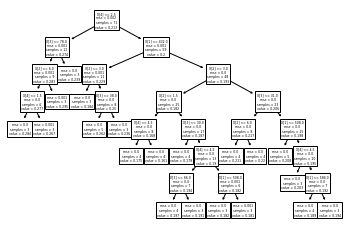

In [108]:
labels = get_labels(data, ignore=[])
x_trn = generate_data(data, labels)
percentiles = [0,1]
cols = len(percentiles)
rows = len(labels)
matrix = torch.zeros(rows, cols)

for col in range(cols):
    alpha = percentiles[col]
    y_trn = get_weigthed_score(data, alpha)
    imp = importance(x_trn, y_trn)
    for row in range(rows):
        matrix[row,col] = imp['imp'][row]

<module 'matplotlib.pyplot' from '/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

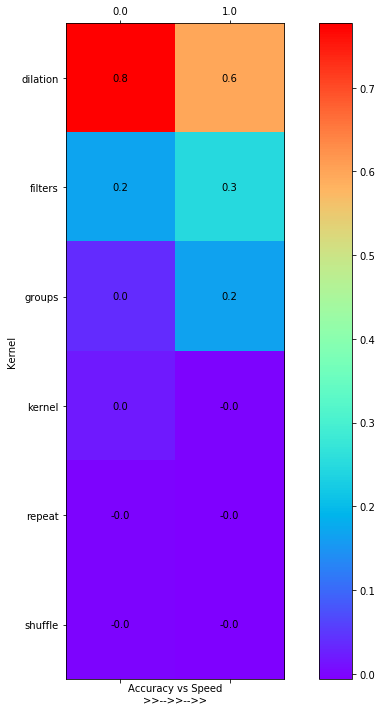

In [97]:
get_matrix_plot(matrix, prettify_labels(labels).values(), ["{0:0.1f}".format(x) for x in percentiles],
                   "Kernel", False, round_ints = False, vmin=matrix.min(), vmax=matrix.max(), legend=True)

      cols       imp
0   repeat  0.850013
1  filters  0.138998
2   groups  0.011559
3   kernel -0.000073
4  shuffle -0.000497
      cols       imp
0   repeat  0.508807
1   groups  0.303510
2  filters  0.189011
3   kernel  0.001119
4  shuffle -0.002448


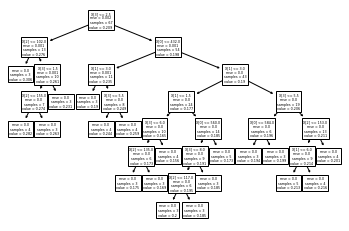

In [120]:
combined = generate_data(data, labels)
combined['kernel'] = combined['kernel']+(combined['kernel']-1)*combined['dilation']
combined = combined.drop(['dilation'], axis=1)
percentiles = [0,1]
cols = len(percentiles)
rows = len(labels)-1
matrix = torch.zeros(rows, cols)

for col in range(cols):
    alpha = percentiles[col]
    y_trn = get_weigthed_score(data, alpha)
    res = importance(combined, y_trn)
    print(res)
    for row in range(rows):
        matrix[row,col] = res['imp'][row]

<module 'matplotlib.pyplot' from '/user/student.aau.dk/jfraus14/.conda/envs/jkbc/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

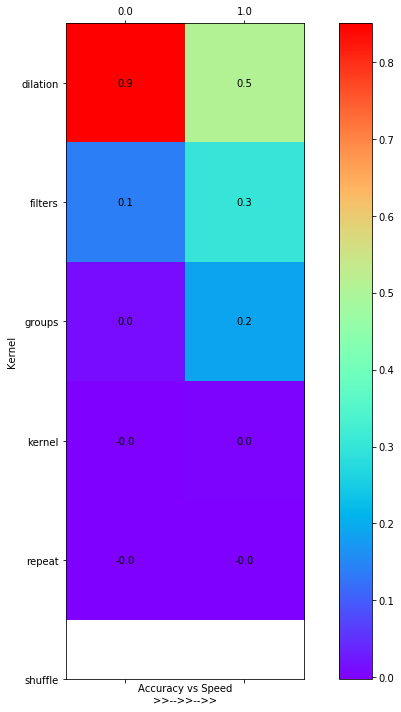

In [121]:
get_matrix_plot(matrix, prettify_labels(labels).values(), ["{0:0.1f}".format(x) for x in percentiles],
                   "Kernel", False, round_ints = False, vmin=matrix.min(), vmax=matrix.max(), legend=True)

In [119]:
combined

,filters,groups,kernel,repeat,shuffle
0,608,4,101,1,0
1,608,2,133,1,0
2,512,2,97,7,1
3,512,2,193,9,1
4,560,4,145,5,1
...,...,...,...,...,...
127,504,8,73,4,1
128,352,2,121,2,1
129,352,4,121,2,1
130,512,4,97,5,0


In [10]:
df_raw

,Name,ID,Name.1,State,Notes,User,Tags,Created,Runtime,Sweep,...,teacher,teacher_name,time_predict,weight_decay,ctc_loss,epoch,read_identity,time,train_loss,valid_loss
0,grateful-terrain-369,vy87ire6,grateful-terrain-369,crashed,-,jgfrausing,RANDOM_SWEEP,2020-05-28T07:18:21.000Z,2450,NaN,...,NaN,NaN,1.843034,0.1,NaN,3,0.861080,NaN,0.325531,0.386431
1,glowing-sea-275,10q27c43,glowing-sea-275,crashed,-,jgfrausing,RANDOM_SWEEP,2020-05-27T07:05:34.000Z,4345,NaN,...,NaN,NaN,3.923419,0.1,NaN,4,0.912327,NaN,0.216687,0.265584
2,wild-feather-400,3qnw1cad,wild-feather-400,crashed,-,jgfrausing,RANDOM_SWEEP,2020-05-29T15:36:24.000Z,3883,NaN,...,NaN,NaN,3.362575,0.1,0.277573,5,0.901688,NaN,0.212712,0.277573
3,sparkling-pond-399,2wobqmzv,sparkling-pond-399,crashed,-,kbargsteen,RANDOM_SWEEP,2020-05-29T15:23:15.000Z,5164,NaN,...,NaN,NaN,2.380895,0.1,NaN,6,0.903990,NaN,0.231117,0.275447
4,glad-feather-390,1jgx5gvl,glad-feather-390,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-29T05:13:12.000Z,4611,NaN,...,NaN,NaN,1.596016,0.1,0.321015,11,0.899822,NaN,0.166814,0.321015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,silver-river-195,2iepm7d5,silver-river-195,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T11:26:09.000Z,15194,NaN,...,NaN,NaN,2.145728,0.1,NaN,27,0.938367,NaN,0.101717,0.205918
132,dulcet-jazz-146,2vnbeih5,dulcet-jazz-146,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-23T07:51:17.000Z,12025,NaN,...,NaN,NaN,1.598462,0.1,NaN,27,0.876321,NaN,0.138075,0.237294
133,silvery-smoke-205,3uae816g,silvery-smoke-205,finished,-,jgfrausing,RANDOM_SWEEP,2020-05-25T18:49:59.000Z,10836,NaN,...,NaN,NaN,1.472418,0.1,NaN,27,0.903619,NaN,0.146840,0.255986
134,zesty-wood-184,7whmgy42,zesty-wood-184,finished,-,kbargsteen,RANDOM_SWEEP,2020-05-25T02:46:26.000Z,18234,NaN,...,NaN,NaN,2.733743,0.1,NaN,28,0.921765,NaN,0.094177,0.184284
